In [186]:

#Question -1 

import pandas as pd
from IPython.display import display, HTML
pd.set_option('display.mpl_style', 'default')
import datetime

def get_occupation(ocp=0):
      ocp_list = ["other or not specified", "academic/educator", "artist", "clerical-admin", "college/grad student",
                  "customer service","doctor/health care", "executive/managerial", "farmer", "homemaker", "K-12 student", 
                  "lawyer", "programmer", "retired", "sales/marketing", "scientist", "self-employed", "technician/engineer", 
                  "tradesman/craftsman", "unemployed", "writer"]
      return ocp_list[int(ocp)]
    
def get_age(age='1'):
    age_dict={'1':  "Under 18",
              '18':  "18-24",
              '25':  "25-34",
              '35':  "35-44",
              '45':  "45-49",
              '50':  "50-55",
              '56':  "56+"}
    return age_dict[str(age)]


def get_user_dataset():
    UserID,Gender,Age,Ocptn,zipcd = [],[],[],[],[]
    User_DataSet = pd.DataFrame()
    #UserID::MovieID::Rating::Timestamp
    with open('users.dat') as f:
        for line in f:
            line = str(line.strip()).split("::")
            UserID.append(line[0])
            Gender.append(line[1])
            Age.append(get_age(age=line[2]))
            Ocptn.append(get_occupation(ocp=line[3]))
            zipcd.append(line[4])
    User_DataSet["userID"] = UserID
    User_DataSet["gender"] = Gender
    User_DataSet["age"] = Age
    User_DataSet["ocptn"] = Ocptn
    User_DataSet["zipCD"] = zipcd
    return User_DataSet

def get_rating_dataset():
    R_UserID,R_MovieID,rating,TimeStamp = [],[],[],[]
    Rating_DataSet = pd.DataFrame()
    with open('ratings.dat') as f:
        #UserID::MovieID::Rating::Timestamp
        for line in f:
            line = str(line.strip()).split("::")
            R_UserID.append(line[0])
            R_MovieID.append(line[1])
            rating.append(line[2])
            TimeStamp.append(line[3])
    #TimeStamp = map(lambda line: datetime.datetime.fromtimestamp(float(line)).strftime('%Y'), TimeStamp)
    Rating_DataSet["userID"] = R_UserID
    Rating_DataSet["movieID"] = R_MovieID
    Rating_DataSet["rating"] = list(map(int, rating))
    Rating_DataSet["timestamp"] = TimeStamp
    return Rating_DataSet

def get_movie_dataset():
    MovieID,Title,Genere = [],[],[]
    Movie_DataSet = pd.DataFrame()
    with open('movies.dat') as f:
        #MovieID::Title::Genres
        for line in f:
            line = str(line.strip()).split("::")
            MovieID.append(line[0])
            Title.append(line[1])
            Genere.append(line[2])
    Movie_DataSet["movieID"] = MovieID
    Movie_DataSet["genere"] = Genere
    Movie_DataSet["title"] = Title
    return Movie_DataSet

def store_hdf5(UR_M_result):
    Merged_hdf_datastore = pd.HDFStore('Merged_hdf_datastore.h5')
    print Merged_hdf_datastore
    Merged_hdf_datastore['UMR_dataframe'] = UR_M_result
    Merged_hdf_datastore
    
    #Read from hdf5 to verify
    #readhdf = pd.read_hdf('Merged_hdf_datastore.h5','UMR_dataframe')  
    #print "*** Printing data from HDF5 ***"
    #display(readhdf)
    
def get_movie_mean_over_45(UR_M_result,filtr = "all"):
    
    if filtr == 'all':
        #Movies rated over 4.5
        grouped = UR_M_result.groupby(['movieID'],as_index=False).rating.mean()
        dfg = grouped.sort_values('rating',ascending=False,inplace=False)
        rated_45 = dfg.query('rating >= 4.5')
        #display(rated_45)  
        print "TOTAL MOVIES WITH MEAN RATING OVER 4.5 : "+str(len(rated_45))
        
    elif filtr == 'M' or 'F':
        #movies over 4.5 among men
        men_rated_movies = UR_M_result.query('gender == @filtr')
        #display(men_rated_movies)
        Men_grouped = men_rated_movies.groupby(['movieID'],as_index=False).rating.mean()
        Men_rated_45 = Men_grouped.query('rating >= 4.5')
        #display(Men_rated_45)
        if filtr == 'M':
            print "TOTAL MOVIES WITH MEAN RATING OVER 4.5 AMONG MEN: "+str(len(Men_rated_45))
        elif filtr == 'F':
            print "TOTAL MOVIES WITH MEAN RATING OVER 4.5 AMONG WOMEN: "+str(len(Men_rated_45))
            
def get_movie_median_over_45(UR_M_result,filtr = "all"):    
    if filtr == 'all':
        #Movies rated over 4.5
        grouped = UR_M_result.groupby(['movieID'],as_index=False).rating.median()
        dfg = grouped.sort_values('rating',ascending=False,inplace=False)
        rated_45 = dfg.query('rating >= 4.5')
        #display(rated_45)  
        print "TOTAL MOVIES WITH MEDIAN RATING OVER 4.5 : "+str(len(rated_45))
        
    elif filtr == 'M' or 'F':
        #movies over 4.5 among men
        men_rated_movies_30y = UR_M_result.query('gender == @filtr')
        men_rated_movies = men_rated_movies_30y[men_rated_movies_30y['age'].isin(["35-44","45-49","50-55","56+"])]
        #display(men_rated_movies)
        Men_grouped = men_rated_movies.groupby(['movieID'],as_index=False).rating.median()
        Men_rated_45 = Men_grouped.query('rating >= 4.5')
        #display(Men_rated_45)
        if filtr == 'M':
            print "TOTAL MOVIES WITH MEDIAN RATING OVER 4.5 AMONG MEN 30+ yrs: "+str(len(Men_rated_45))
        elif filtr == 'F':
            print "TOTAL MOVIES WITH MEDIAN RATING OVER 4.5 AMONG WOMEN 30+ yrs: "+str(len(Men_rated_45))
            

#print "*** User Dataset ***"
User_DataSet = get_user_dataset()
#display(User_DataSet)
#print "*** Movie Dataset ***"
Movie_DataSet = get_movie_dataset()
#display(Movie_DataSet)
#print "*** Rating Dataset ***"
Rating_DataSet = get_rating_dataset()
#display(Rating_DataSet)
#
#Merge User and rating table with left outer join
#
UR_result = pd.merge(User_DataSet, Rating_DataSet, how='inner', on='userID',left_index=False, right_index=False, sort=True,
               suffixes=('_x', '_y'), copy=True, indicator=False)
#Merge User+rating table with Movie table - left outer join
UR_M_result = pd.merge(UR_result, Movie_DataSet, how='inner', on='movieID',left_index=False, right_index=False, sort=True,
               suffixes=('_x', '_y'), copy=True, indicator=False)
#display(UR_result)
print "MERGED DATASET"
display(UR_M_result)
store_hdf5(UR_M_result)  

MERGED DATASET


,userID,gender,age,ocptn,zipCD,movieID,rating,timestamp,genere,title
0,1,F,Under 18,K-12 student,48067,1,5,978824268,Animation|Children's|Comedy,Toy Story (1995)
1,10,F,35-44,academic/educator,95370,1,5,978226474,Animation|Children's|Comedy,Toy Story (1995)
2,1000,F,25-34,doctor/health care,90027,1,5,975041651,Animation|Children's|Comedy,Toy Story (1995)
3,1001,M,25-34,college/grad student,90210,1,4,976296608,Animation|Children's|Comedy,Toy Story (1995)
4,1004,M,25-34,clerical-admin,95136,1,5,975045804,Animation|Children's|Comedy,Toy Story (1995)
5,1008,M,35-44,clerical-admin,77064,1,4,975030379,Animation|Children's|Comedy,Toy Story (1995)
6,1010,M,25-34,other or not specified,10310,1,2,975220910,Animation|Children's|Comedy,Toy Story (1995)
7,1014,F,45-49,technician/engineer,03054,1,3,975015612,Animation|Children's|Comedy,Toy Story (1995)
8,1015,M,35-44,clerical-admin,11220,1,5,975017987,Animation|Children's|Comedy,Toy Story (1995)
9,1017,M,35-44,other or not specified,30906,1,4,975009586,Animation|Children's|Comedy,Toy Story (1995)


<class 'pandas.io.pytables.HDFStore'>
File path: Merged_hdf_datastore.h5
/UMR_dataframe            frame        (shape->[1000209,10])


In [185]:
movie_ratings = UR_M_result.groupby(['title','rating'],as_index=True).rating.size()#.unstack(1).fillna(0)[10:20]#.to_frame()
#display(movie_ratings)

In [187]:
#Get movie and title count
d2 = UR_M_result[["title","rating"]]
d3 = d2.groupby(["rating"]).rating.size()#.sort_values(ascending=False)
d4 = d3[:50]


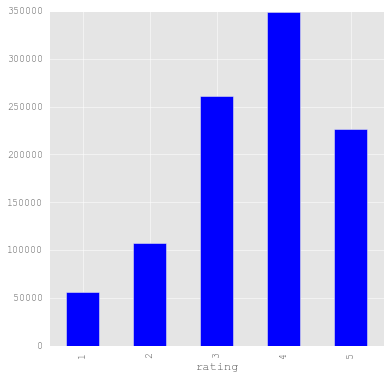

In [232]:
#Plot a histogram of the ratings of all movies.
import matplotlib as plt
%matplotlib inline
matplotlib.style.use('ggplot')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6 #w
fig_size[1] = 6 #H
plt.rcParams["figure.figsize"] = fig_size
d3.plot(kind="bar")

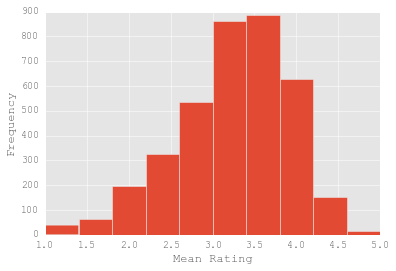

In [228]:
#Get the *number* of ratings each movie recieved.
import numpy as np
movie_grp_rating_count = UR_M_result.groupby(['title'],as_index=True).rating.mean()#.sort_values(ascending=False)
hh = movie_grp_rating_count 
#Plot a histogram of the *number* of ratings each movie recieved.
import matplotlib.pyplot as plt
import matplotlib
plt.figure()
matplotlib.style.use('ggplot')
plt.xlabel('Mean Rating')
plt.ylabel('Moviecounts')
plt.grid(True)
#plt.hist(movie_grp_rating_count, bins=(.5,1,1.5,2,2.5,3,3.5,4,4.5,5), normed=False)
movie_grp_rating_count.plot(kind="hist")

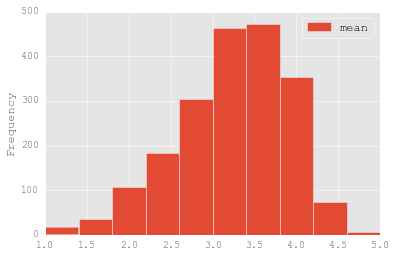

In [230]:
mean_rating = UR_M_result.groupby(['title'],as_index=False).rating.mean()#.sort_values(ascending=False)
hh = pd.DataFrame({'count' : rating_count}).reset_index()
hh["mean"] = mean_rating["rating"]
gg = hh.query('count >= 100')
# the average rating for movies which are rated more than 100 times.
#rating_count = UR_M_result.groupby(['title'],as_index=False).rating.size().sort_values(ascending=False) 
pp = gg[["mean"]]
pp.plot(kind='hist')

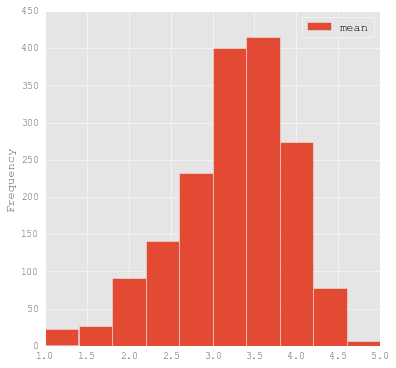

In [234]:
#Hist on the movies rated less than 100
mean_rating = UR_M_result.groupby(['title'],as_index=False).rating.mean()#.sort_values(ascending=False)
h = pd.DataFrame({'count' : rating_count}).reset_index()
h["mean"] = mean_rating["rating"]
g = hh.query('count < 100')
# the average rating for movies which are rated more than 100 times.
#rating_count = UR_M_result.groupby(['title'],as_index=False).rating.size().sort_values(ascending=False) 
ll = gg[["mean"]]
ll.plot(kind='hist')

In [ ]:
''' CONCLUSION '''
* What do you observe about the tails of the histogram where you use all the movies versus the one where you 
    only use movies rated more than 100 times?
    => The tail is much fatter in case of "all movies" compared to movies with greater than 100 count.
       which means more data is distributed at the extreams in case of "all movies" and less data is distributed around the average.

* Which highly rated movies would you trust are actually good?  Those rated more than 100 times or those rated less than 100 times?
    => With the given dataset, movies rated more than 100 times can be trusted over ones that are rated less than 100 times, as we can see the 
       tail is much fatter with the latter one.